In [24]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

from sequential_ft_transformer.fttransformer import ft_transformer
from sequential_ft_transformer.preprocessing import sq_df_to_dataset, download_data
from sequential_ft_transformer.plotting import plot_importances, plot_training_hist


## Download Data

In [25]:
data_folder = "../data/"
seq_length = 1

In [26]:
CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

download_data(train_data_url, data_folder, "adult_train.csv")
download_data(test_data_url, data_folder, "adult_test.csv")

train_data = pd.read_csv(os.path.join(data_folder, "adult_train.csv"), header=None, names=CSV_HEADER)
test_data = pd.read_csv(os.path.join(data_folder, "adult_test.csv"), header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

adult_train.csv already exists in ../data/
adult_test.csv already exists in ../data/
Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


In [27]:
train_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Preprocess

In [28]:
# Column information
NUMERIC_FEATURES = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
NUMERIC_FEATURES = sorted(NUMERIC_FEATURES)
CATEGORICAL_FEATURES = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'native_country']
CATEGORICAL_FEATURES = sorted(CATEGORICAL_FEATURES)

FEATURES = sorted(list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES))
LABEL = 'income_bracket'

In [29]:
# encoding as binary target
train_data[LABEL] = train_data[LABEL].apply(lambda x: int(x == ' >50K')) 
test_data[LABEL] = test_data[LABEL].apply(lambda x: int(x == ' >50K.'))

In [30]:
train_data = train_data.dropna()
test_data = test_data.dropna()

In [31]:
train_input = train_data[FEATURES]
train_labels = train_data[LABEL]

test_input = test_data[FEATURES]
test_labels = test_data[LABEL]

## Get Lookup Tables for Each Categorical Column

In [32]:
cat_lookups = dict()
feature_unique_counts = dict()
num_oov_indices = 1
for cat in CATEGORICAL_FEATURES:
    unique_values = list(np.unique(train_input[cat]).astype(str))
    feature_unique_counts[cat] = len(unique_values) + num_oov_indices
    lookup = keras.layers.StringLookup(vocabulary=unique_values, num_oov_indices=num_oov_indices)
    cat_lookups[cat] = lookup

## Convert Each Categorical String to an ID

In [33]:
for cat in CATEGORICAL_FEATURES:
    train_input[cat] = cat_lookups[cat](train_input[cat])
    test_input[cat] = cat_lookups[cat](test_input[cat])

/tmp/ipykernel_52295/1451819549.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_input[cat] = cat_lookups[cat](train_input[cat])
/tmp/ipykernel_52295/1451819549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_input[cat] = cat_lookups[cat](test_input[cat])


In [34]:
train_input.loc[:, CATEGORICAL_FEATURES] = train_input[CATEGORICAL_FEATURES].astype(int)
test_input.loc[:, CATEGORICAL_FEATURES] = test_input[CATEGORICAL_FEATURES].astype(int)

train_input.loc[:, NUMERIC_FEATURES] = train_input[NUMERIC_FEATURES].astype(float)
test_input.loc[:, NUMERIC_FEATURES] = test_input[NUMERIC_FEATURES].astype(float)

In [35]:
train_labels = train_labels.to_frame(name=LABEL)
test_labels = test_labels.to_frame(name=LABEL)

In [36]:
x_train, x_val, y_train, y_val = train_test_split(train_input, train_labels, test_size=0.2)

## Create TF Datasets

In [37]:
batch_size = 1000
train_dataset = sq_df_to_dataset(
    x_train, 
    seq_length, 
    target_df=y_train, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    batch_size=batch_size
)
val_dataset = sq_df_to_dataset(
    x_val, 
    seq_length, 
    target_df=y_val, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, # No shuffle
    batch_size=batch_size
)  
test_dataset = sq_df_to_dataset(
    test_input, 
    seq_length, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, 
    batch_size=batch_size) # No target, no shuffle

## Linear Numerical Embedding FT-Transformer

In [38]:
# Explanations need to be set to false until the following bug is fixed: https://github.com/keras-team/keras/issues/19303
EXPLANATIONS = False 
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 10

In [39]:
model = ft_transformer(
    out_dim=1,
    out_activation='sigmoid',
    numerical_features=NUMERIC_FEATURES,
    categorical_features=CATEGORICAL_FEATURES,
    feature_unique_counts=feature_unique_counts,
    seq_length=seq_length,
    numerical_embedding_type='linear',
    explainable=EXPLANATIONS
)


optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

loss_dict = {"output": keras.losses.BinaryCrossentropy()}
metrics_dict = {"output": [keras.metrics.AUC(name="PR AUC", curve='PR')]}
if EXPLANATIONS:
    loss_dict.update({"importances": None})
    metrics_dict.update({"importances": None})
model.compile(
    optimizer = optimizer,
    loss = loss_dict,
    metrics= metrics_dict,
)

early = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]

In [40]:
hist = model.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/10
23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - PR AUC: 0.3399 - loss: 0.5729

2024-03-29 20:24:38.288659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - PR AUC: 0.3629 - loss: 0.5610

2024-03-29 20:24:42.582868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - PR AUC: 0.3679 - loss: 0.5585 - val_PR AUC: 0.6746 - val_loss: 0.3969
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - PR AUC: 0.6805 - loss: 0.3879 - val_PR AUC: 0.7083 - val_loss: 0.3531
Epoch 3/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - PR AUC: 0.7281 - loss: 0.3579

2024-03-29 20:24:44.473507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-29 20:24:44.512881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - PR AUC: 0.7259 - loss: 0.3492 - val_PR AUC: 0.7107 - val_loss: 0.3414
Epoch 4/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - PR AUC: 0.7087 - loss: 0.3313

2024-03-29 20:24:44.885969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-29 20:24:44.928648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - PR AUC: 0.7179 - loss: 0.3450 - val_PR AUC: 0.7198 - val_loss: 0.3404
Epoch 5/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - PR AUC: 0.7594 - loss: 0.3418

2024-03-29 20:24:45.299537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-29 20:24:45.337804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - PR AUC: 0.7343 - loss: 0.3429 - val_PR AUC: 0.7249 - val_loss: 0.3383
Epoch 6/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - PR AUC: 0.7026 - loss: 0.3423

2024-03-29 20:24:45.721055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-29 20:24:45.767372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - PR AUC: 0.7310 - loss: 0.3349 - val_PR AUC: 0.7237 - val_loss: 0.3516
Epoch 7/10
 7/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - PR AUC: 0.7286 - loss: 0.3523

2024-03-29 20:24:46.150512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-29 20:24:46.189005: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - PR AUC: 0.7203 - loss: 0.3463 - val_PR AUC: 0.7286 - val_loss: 0.3294
Epoch 8/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - PR AUC: 0.7699 - loss: 0.3325

2024-03-29 20:24:46.475382: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-29 20:24:46.515205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - PR AUC: 0.7436 - loss: 0.3332 - val_PR AUC: 0.7321 - val_loss: 0.3238
Epoch 9/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - PR AUC: 0.7329 - loss: 0.3500

2024-03-29 20:24:46.894980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-29 20:24:46.935613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - PR AUC: 0.7418 - loss: 0.3277 - val_PR AUC: 0.7317 - val_loss: 0.3224
Epoch 10/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - PR AUC: 0.7275 - loss: 0.3147

2024-03-29 20:24:47.322246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-29 20:24:47.360204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - PR AUC: 0.7406 - loss: 0.3277 - val_PR AUC: 0.7313 - val_loss: 0.3244


2024-03-29 20:24:47.742219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-29 20:24:47.781208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


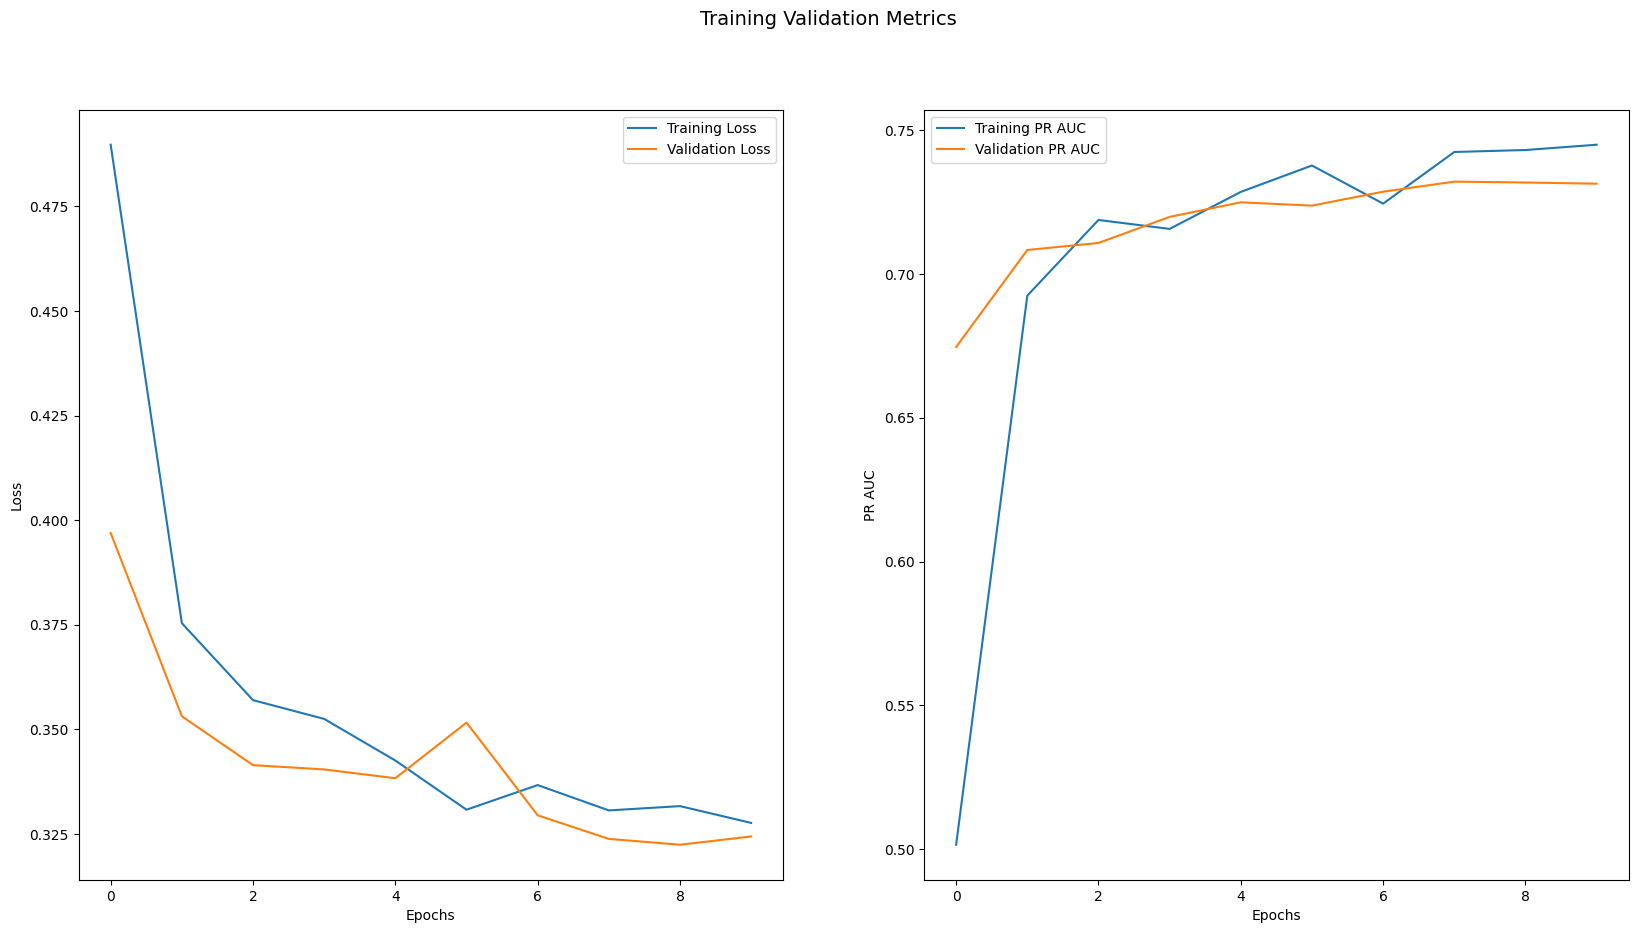

In [41]:
hist_plot = plot_training_hist(hist.history, EXPLANATIONS)

In [42]:
preds = model.predict(test_dataset)
print("Test ROC AUC:", np.round(roc_auc_score(test_data[LABEL], preds['output'].ravel()), 4))
print("Test PR AUC:", np.round(average_precision_score(test_data[LABEL], preds['output'].ravel()), 4))
print("Test Accuracy:", np.round(accuracy_score(test_data[LABEL], preds['output'].ravel()>0.5), 4))

# Reported accuracy - 0.858

 1/17 ━━━━━━━━━━━━━━━━━━━━ 14s 900ms/step

2024-03-29 20:24:48.896306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step 
Test ROC AUC: 0.9019
Test PR AUC: 0.7429
Test Accuracy: 0.8495


## Explainability

In [43]:
if 'importances' in preds.keys():
    importances = preds['importances']
    importances_df = pd.DataFrame(importances[:, :-1], columns = FEATURES)
    importances_fig, total_importances = plot_importances(
        importances_df, 
        title="Importances for FT-Transformer"
    )

In [44]:
if 'importances' in preds.keys():
    # Largest prediction
    max_idx = np.argsort(preds['output'].ravel())[-1]
    example_importance_linear = importances_df.iloc[max_idx, :].sort_values(ascending=False).rename("Importance").to_frame().join(
        test_data.iloc[max_idx, :].rename("Example Value")
    ).head(5)
    print(f"Top 5 contributions to row {max_idx} which was scored {str(np.round(preds['output'].ravel()[max_idx], 4))}")
    display(example_importance_linear)

    # Smallest one
    min_idx = np.argsort(preds['output'].ravel())[0]
    example_importance_linear = importances_df.iloc[min_idx, :].sort_values(ascending=False).rename("Importance").to_frame().join(
        test_data.iloc[min_idx, :].rename("Example Value")
    ).head(5)
    print(f"Top 5 contributions to row {min_idx} which was scored {str(np.round(preds['output'].ravel()[min_idx], 4))}")
    display(example_importance_linear)